In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files
from itertools import product
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
from google.colab import drive
drive.mount('/content/drive')
%load_ext google.colab.data_table

Authenticated
Mounted at /content/drive


In [ ]:
%%bigquery alllabs --project icu-elos
WITH labitem AS (SELECT
    a.itemid,b.label,
    COUNT(*) AS cnt
FROM `physionet-data.mimic_hosp.labevents` as a
left join`physionet-data.mimic_hosp.d_labitems` as b
on a.itemid = b.itemid
GROUP BY a.itemid,b.label
HAVING cnt > 500) select
a.subject_id,a.hadm_id,a.itemid,labitem.cnt,labitem.label,a.charttime,a.valuenum
FROM `physionet-data.mimic_hosp.labevents` as a
inner join labitem
on a.itemid = labitem.itemid

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:

SELECT
   a.itemid,b.label,b.category,
   COUNT(distinct hadm_id) AS hadm_id_count,
   COUNT(*) AS totalcnt,
   count(distinct subject_id) subject_id_count
FROM `physionet-data.mimic_hosp.labevents` as a
left join`physionet-data.mimic_hosp.d_labitems` as b
on a.itemid = b.itemid
GROUP BY a.itemid, b.label,b.category
ORDER BY totalcnt DESC;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery morningroutinelab --project icu-elos
WITH cohort AS (
  SELECT
    hadm_id,
    itemid,
    charttime,
    subject_ID,
    valuenum
  FROM
    `physionet-data.mimiciv_hosp.labevents`
),
labcnt AS (
  SELECT
    hadm_id,
    charttime,
    COUNT(DISTINCT itemid) AS cnt
  FROM cohort
  GROUP BY hadm_id, charttime
)
SELECT
  cohort.*,
FROM
  cohort
JOIN
  labcnt ON cohort.hadm_id = labcnt.hadm_id AND cohort.charttime = labcnt.charttime

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
from google.colab import files
rawData=pd.DataFrame(morningroutinelab)
rawData.to_csv('rawData.csv', index=False)

# Download the CSV file
files.download('rawData.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rawData.head()

,hadm_id,itemid,charttime,subject_ID,valuenum
0,25637195,50878,2160-08-07 23:35:00,16454052,47.0
1,29810405,50878,2173-05-28 00:39:00,16484690,54.0
2,23167854,50878,2173-07-12 04:30:00,16484690,52.0
3,26871531,50878,2144-11-16 06:06:00,16488736,20.0
4,26012970,50878,2182-03-04 22:17:00,16509298,27.0


In [ ]:
rawData

,hadm_id,itemid,charttime,subject_ID,valuenum
0,25637195,50878,2160-08-07 23:35:00,16454052,47.00
1,29810405,50878,2173-05-28 00:39:00,16484690,54.00
2,23167854,50878,2173-07-12 04:30:00,16484690,52.00
3,26871531,50878,2144-11-16 06:06:00,16488736,20.00
4,26012970,50878,2182-03-04 22:17:00,16509298,27.00
...,...,...,...,...,...
60601906,21857761,50821,2129-03-11 07:30:00,17970878,216.00
60601907,25874253,52069,2167-08-27 03:53:00,17973277,0.00
60601908,29058455,51133,2188-11-01 07:40:00,17976662,0.97
60601909,28790304,50808,2172-01-29 04:14:00,17977369,1.22


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
results=[] #itemID, then R^2
for currCol in labIDS['itemid']:
  curr=int(currCol)
  currData=rawData[rawData['itemid']==curr]
  currData.dropna()
  if(len(currData)==0):
    continue


  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()

  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600
  currData = currData.dropna()
  finalData=currData[currData['delta_time']<=24]
  x = currData['valuenum_yesterday']
  y = currData['valuenum']
  if(len(currData)==0):
    continue
  try:
  # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value**2
    print((curr,r_squared,len(currData)))
    results.append((curr,r_squared,len(currData)))
  except:
    print(f"{curr}doesnt work")





<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50801, 0.12048119286772765, 4710)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50802, 0.23844441268654343, 397417)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50803, 0.6134264180990574, 1055)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50804, 0.4223651862277113, 397389)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50805, 0.3843916727669001, 154)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50806, 0.3098995836144929, 32338)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50808, 0.0006880930376417957, 221723)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50809, 0.0985412772380238, 141854)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50810, 0.19891120931043535, 62949)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50811, 0.20020855143989455, 62956)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50813, 3.4171732433923176e-11, 248941)
(50814, 0.09740616175393255, 250)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50815, 0.13858334316860033, 2285)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50816, 0.10776191310193545, 45845)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50817, 0.11084943046610303, 125349)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50818, 0.32456262416595505, 397392)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50819, 0.09911372124703317, 40296)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50820, 0.1369264991753274, 439680)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50821, 0.14081021574901204, 397581)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50822, 0.012582116561439836, 134624)
(50823, 0.13110724539293586, 4723)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50824, 0.2006311164285617, 53694)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50825, 0.10720735407097248, 74191)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50826, 0.16880031821200678, 31888)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52024, 0.5141302228135527, 351)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50831, 0.21081185650087844, 689)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50852, 0.9216300682199242, 1021)
(50853, 0.6376801494085178, 281)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50856, 0.31227543865830076, 193)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50861, 0.3295630911165226, 382450)


<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600


(50862, 0.4930441606272995, 163552)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50863, 0.6609579765203012, 374213)
(50864, 0.2053038078136602, 175)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50865, 0.024924519459639388, 312)
(50866, 0.13089395977777354, 991)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50867, 0.1663038282465509, 20361)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50868, 0.2734761486060326, 1536355)
(50869, 0.5894896582733812, 7)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50877, 0.0, 1)


<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600


(50878, 0.15548094150655778, 385782)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50881, 0.7130461101414568, 74)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50882, 0.37163150320652805, 1540528)
(50883, 0.5965119552541779, 14008)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50884, 0.6325937650518011, 13908)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50885, 0.6883266339325436, 374980)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50889, 0.29791061307385946, 9684)
(50890, 0.6876728975682755, 229)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50891, 0.7458212349598958, 218)
(50892, 0.9911342600118936, 39)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50893, 0.3373835252366, 1309808)
(50894, 0.9153268924831918, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50895, 0.7308772535306761, 250)
(50896, 0.50774594795656, 246)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50898, 0.9986000701952931, 9)
(50899, 0.26378642025305055, 267)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50900, 0.9352530753333493, 100)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50902, 0.4253237725014877, 1590439)
(50903, 0.8288303022648745, 821)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50904, 0.7971036484411532, 837)
(50905, 0.7701006395643585, 700)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50906, 0.6982272458842876, 73)
(50907, 0.7264372796829817, 1083)
(50908, 0.6550655134007511, 11141)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50909, 0.04674976054402252, 6187)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50910, 0.32144837026704853, 83827)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50911, 0.402805652091035, 72471)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50912, 0.7490113423407314, 1566610)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50914, 0.10102878751172555, 8141)
(50915, 0.44103639474215317, 663)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50916, 0.909528135346743, 11)
(50917, 0.3118401811521535, 3369)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50921, 0.0, 1)
(50922, 0.18177807990652153, 38)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50924, 0.1919162921084441, 5262)
(50925, 0.48491321103100554, 243)


<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600
<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

(50926, 0.0009781742021865649, 12)
(50927, 0.5346719923400142, 491)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50929, 3.499899050181596e-08, 1588)
(50930, 0.7461606596729303, 2450)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50931, 0.08855123595941132, 1517817)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50934, 0.0028691473064425574, 679340)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50935, 0.6902647257524791, 5392)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50945, 9.668281518825535e-05, 9)
(50946, 0.5690158572528783, 197)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50947, 0.7035379406482966, 679327)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50949, 0.7639367170933585, 671)
(50950, 0.8272295197113603, 1011)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50951, 0.7601363940424056, 593)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50952, 0.43795408304584227, 3455)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50953, 0.7031764404386256, 2900)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50954, 0.08912425610525096, 199509)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50956, 0.02124121111143028, 29021)
(50957, 0.19949319900821755, 991)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50958, 0.22072120807237566, 9)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50960, 0.06956234671462248, 1409547)
(50961, 4.553176734605681e-05, 3641)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50962, 0.3085280464965737, 5)
(50963, 0.523571946221863, 2399)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50964, 0.5445109689980618, 22157)
(50965, 0.38300696791900435, 917)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50966, 0.4298621747446155, 1539)
(50967, 0.13916981052640798, 13070)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50968, 0.16918465740566943, 298)
(50969, 0.41583824336046993, 305)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50970, 0.2181699328187468, 1313075)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50971, 0.14597629008694676, 1621949)
(50972, 0.2182628082052541, 5)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50973, 0.5315833765119189, 100)
(50974, 0.9178478528841066, 81)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50976, 0.5978362245686337, 3495)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50978, 0.175669410917121, 2463)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50980, 0.5293585457547723, 35)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50981, 0.06799321342148702, 207)
(50982, 0.9409689389136298, 8)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50983, 0.356701569137213, 1605627)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50986, 0.11807682431964124, 36708)
(50988, 0.2520703705780143, 32)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50989, 0.0, 1)
(50990, 1.0, 2)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50991, 0.9743454346066086, 4)
(50992, 0.999796354333511, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50993, 0.7692018430563343, 3663)
(50994, 0.62920581711491, 1086)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50995, 0.5920402222133244, 1141)
(50996, 0.9847402014969464, 41)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50997, 0.028984534419431635, 997)
(50998, 0.7015703436954308, 2900)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51000, 0.2024352040486006, 8362)
(51001, 0.5854086221417822, 892)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51003, 0.6135273175708426, 63805)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51005, 0.7319414351330792, 251)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51006, 0.5926515391825062, 1554218)
(51007, 0.3899215562656798, 50552)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51008, 0.2060471419647222, 3815)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51009, 0.0395743330151185, 58505)
(51010, 0.6100869549524345, 678)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51564, 0.9960865598873893, 167)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51567, 0.2556813552541862, 17)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51579, 0.9942317471417397, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51587, 0.9225798411519456, 12)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51598, 0.27252628672629486, 152)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51613, 0.9220176982098254, 874)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51615, 0.994666428555033, 4)
(51616, 0.9649049876846175, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51617, 0.6094173206472671, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51621, 7.720195641924789e-05, 7)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51625, 0.2686967530711638, 254)
(51626, 0.505397935335892, 235)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51627, 0.34042731389702413, 244)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51648, 0.7675215387697855, 9)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51651, 0.21582649390725656, 15)
(51652, 0.11323550107882309, 7)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51654, 0.7346522454245877, 5)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51657, 0.20901924167223102, 618)
(51658, 0.780390046939783, 168)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51659, 0.9429075355523111, 506)
(51660, 0.9953210768996171, 17)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51661, 0.9969903238980294, 15)
(51662, 0.9902774102267028, 24)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51663, 0.9054532395901023, 467)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51677, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51678, 0.0629585274109585, 679337)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51689, 0.03955183293377535, 10)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51726, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51732, 0.44714851699889324, 43)
(51733, 0.04189044172799742, 8)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51734, 0.09249800829512678, 138)
(51735, 0.8940483985919, 77)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51736, 0.1176911537124639, 80)
(51737, 0.8012231386773319, 152)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51742, 0.9205321726509318, 3)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51744, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51749, 0.10703913952239254, 21)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51754, 0.9643373813871763, 3)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51762, 0.004443844863363804, 16)
(51763, 0.7059056019062295, 15)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51764, 0.9860628979777918, 10)
(51765, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51768, 0.344512482422313, 9)
(51769, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51061, 0.24433734939759036, 4)
(51062, 0.6066139879357378, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51063, 0.00418947953804182, 12)
(51064, 0.40569757368192416, 14)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51065, 0.19339711923990185, 17)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51066, 0.8815266866612141, 6)
(51067, 0.1146136407597568, 243)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51068, 0.301468016224501, 50)
(51069, 0.602468778491718, 112)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51070, 0.1786799211065373, 114)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51072, 0.09021293757715555, 14)
(51073, 0.024747008798706966, 15)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51076, 0.22196269509707806, 27)
(51077, 0.31244953634520733, 174)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51078, 0.1771906073842335, 7814)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51080, 0.52624898275598, 7)
(51081, 0.9513625090309505, 7)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51082, 0.2233959730100889, 16715)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51084, 0.4628378141302538, 11)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51087, 0.4479218484245763, 330)
(51088, 0.07027982659315227, 113)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51093, 0.19966029464174442, 14532)
(51094, 0.3824496715128199, 440)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51095, 0.2127604083256982, 204)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51097, 0.13931212612639116, 9780)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51099, 0.00290475807366461, 1914)


<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600
<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

(51100, 0.1891848124721866, 13060)
(51101, 0.41666666666666663, 7)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51102, 0.47123426644096333, 2134)


<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600
<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

(51104, 0.22077392696923814, 6363)
(51105, 0.19064980827823189, 83)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51106, 0.18040717241353352, 7)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51108, 0.5978653812285721, 456)
(51109, 0.04105590714721725, 7)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52004, 0.5123518849975583, 156)
(52005, 0.29514055472293066, 153)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52006, 0.013930962423981034, 148)
(52007, 0.22606467097069544, 163)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52008, 0.4189310990254707, 157)


<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600
<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

(52009, 0.6807389320677867, 135)
(52010, 0.7597425389129561, 143)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52012, 0.9355414259988986, 5)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52018, 0.9999518490326015, 15)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52020, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50835, 0.3808152015482103, 921)
(50836, 0.18784799390352339, 960)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50837, 0.03719387755102041, 6)
(50838, 0.0018978456946777838, 355)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50839, 0.46900831087151845, 7)
(50840, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50841, 0.23831103712175536, 373)
(50842, 0.1906365389363958, 707)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50843, 0.7549634992153256, 668)
(50844, 0.00017360604669457443, 19)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50846, 1.0, 2)
(50847, 0.23365717432347322, 6)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50848, 0.002307828865613349, 10)
(50849, 6.602993336197392e-05, 1433)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(50850, 0.2775667102127482, 70)
(50851, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51046, 0.39356484992583635, 462)
(51047, 0.42882240769539703, 244)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51049, 0.15040311181340754, 25)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51051, 0.6204695739381955, 576)
(51052, 0.8268913077575223, 101)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51053, 0.29165909301428244, 992)
(51054, 0.08297538246274526, 1122)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51056, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51059, 0.5251068751078523, 1107)
(51060, 0.18472789485489527, 178)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51921, 0.7478317120294544, 148)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51020, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51022, 1.0, 2)
(51023, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51024, 1.0, 2)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51025, 0.48982247904628046, 4)
(51026, 0.004172030587725012, 206)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51027, 0.6096839456084014, 11)
(51028, 0.012372991783281578, 50)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51029, 1.0, 2)
(51030, 0.9700785336022167, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51032, 0.004815846555668047, 75)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51034, 0.9511518100546201, 10)
(51035, 0.6368418091475435, 10)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51036, 0.005608103146036445, 8)
(51037, 1.0, 2)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51040, 1.0, 2)
(51041, 0.9471444394409991, 3)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51042, 0.9985202722699024, 4)
(51043, 0.9510767133011293, 7)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51044, 0.06731858915898559, 27)
(51045, 0.931422970143598, 7)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51903, 1.0, 2)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51790, 0.23114162756147302, 1137)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51795, 0.010324960584354484, 60)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51802, 0.001484307451926943, 1223)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51130, 0.3441893396819168, 180)
(51131, 0.20524788048709403, 181)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51132, 0.4992534956113641, 180)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51133, 0.6828017427873524, 88231)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51138, 0.6060514019539011, 38)
(51139, 0.8649848806060005, 38)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51140, 0.09514545190460352, 358)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51143, 0.056436579021809215, 79621)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51144, 0.10617704409839672, 83777)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51146, 0.13453937077370787, 191340)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51148, 0.38816255293792873, 14012)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51150, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51162, 0.22153051564750292, 4)
(51163, 0.9789198104884038, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51165, 0.10898106908071287, 44)
(51166, 0.002433575482949946, 44)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51169, 0.019129270086084525, 44)
(51170, 1.0069406405454593e-07, 44)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51174, 0.6543735705116549, 24)
(51175, 0.41078622477357735, 25)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51176, 0.5765856960198642, 178)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51178, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51180, 0.6764147259547834, 179)
(51181, 0.9426641664339703, 181)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51185, 0.7337742757246979, 19)
(51186, 0.5531722002082726, 19)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51188, 1.0, 2)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51194, 0.7251865921376662, 179)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51196, 0.41727372430835075, 323)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51199, 0.9107679454146277, 11)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51200, 0.36229401657334515, 191349)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51202, 0.12309650595074953, 6)
(51203, 0.03721954263930802, 58)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51204, 0.31047849726276017, 26)
(51205, 0.22251277581479142, 52)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51206, 0.6756717533094404, 345)
(51207, 1.0, 2)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51208, 0.09019372079108409, 10)
(51209, 0.24748833335096307, 57)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51210, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51212, 0.031640166767520725, 15)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51214, 0.5067913536935558, 58695)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51218, 0.22147658376367843, 16535)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51221, 0.5820379564638413, 1568226)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51222, 0.6138348004465193, 1452692)
(51223, 0.833616437795469, 11)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51224, 0.91550382432372, 12)
(51225, 0.23826782441107605, 10)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51226, 0.4433862943671618, 12)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51227, 0.2381654571461002, 12)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51228, 0.11780909707252572, 2361)
(51229, 0.23318151046942687, 554)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51232, 0.16720229823452207, 57)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51237, 0.24643830480541185, 692040)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51244, 0.3950132396000223, 191354)
(51245, 0.2862743284044225, 182)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51248, 0.8669903868102593, 1437592)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51249, 0.6343264998700952, 1437973)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51250, 0.8387104100078333, 1437770)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51251, 0.10395104972111265, 80592)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51254, 0.17579472828396542, 191349)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51255, 0.128787887476125, 80053)


<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600


(51256, 0.4686476902636063, 191310)
(51257, 0.2891092758230128, 23866)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51259, 0.41250838980278887, 3621)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51263, 0.2824001764489204, 313)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51265, 0.6046181235288821, 1468179)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51269, 0.6192880774330126, 3069)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51271, 0.8798847904431764, 13)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51273, 0.8478638192995136, 9)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51274, 0.22602916411775756, 692063)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51275, 0.17066073858100908, 744306)
(51276, 0.5340536405699581, 24)


<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600
<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

(51277, 0.7782802920737832, 1435931)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51279, 0.6381719421845263, 1437762)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51281, 0.0, 1)
(51282, 0.5600563683136968, 2492)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51283, 0.5777887565515826, 3957)
(51284, 0.4862258244442238, 345)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51288, 0.6402158131607688, 1787)
(51289, 0.12025554173780144, 107)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51297, 0.14052194541508342, 179)
(51298, 0.240675749134957, 55)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51299, 0.17982683513901854, 67)
(51300, 0.7407478106317162, 182)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51301, 0.10765367941305726, 1439276)
(51302, 0.6000000000000001, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52069, 0.6005325477108294, 88230)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52073, 0.3728999350443357, 88240)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52074, 0.3628179938221744, 88232)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52075, 0.4810640706249356, 88299)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52107, 0.0, 1)
(52108, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52109, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52132, 1.0, 2)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52135, 0.27413679510295336, 39571)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52172, 0.31710296878883276, 680140)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52220, 0.0, 1)
(52769, 0.1591859062941694, 182)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

51463doesnt work


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51471, 0.06106272768395337, 13)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51476, 0.031165454483018707, 24605)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51478, 0.11894424855074877, 2761)
(51479, 0.010500068165661146, 990)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51482, 0.010049586198751227, 8217)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51484, 0.15714341542134327, 2925)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51491, 0.1575385637839572, 69597)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51492, 0.16612855601856968, 19352)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51493, 0.079223256037748, 27645)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51498, 2.9714901867146247e-12, 67480)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51501, 0.00019584990882206348, 314)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51507, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51514, 0.06865235306313651, 4266)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51516, 0.08686556153482904, 28742)
(51517, 1.0, 2)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51110, 0.22515093683824325, 27)
(51111, 0.049807122303195124, 15)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51112, 0.0001395695056137959, 15)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51114, 0.19041503597822154, 194)
(51115, 0.20929744622675991, 55)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51116, 0.17434652197447653, 2914)
(51117, 0.11017144988211344, 2244)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51118, 0.013685808483968373, 1593)
(51119, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51120, 0.024910854734916145, 2912)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51122, 0.16974861010394016, 11)
(51123, 0.5305347219827514, 293)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51124, 0.4197210802621845, 69)
(51125, 0.22583107795764668, 2915)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51127, 0.06042137986559921, 2810)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52065, 0.019610314403487265, 2916)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51440, 0.06644875985387427, 11)
51441doesnt work


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51442, 0.14453418482344088, 19)
(51443, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51444, 0.2283344620225768, 183)
(51445, 0.13718814723607808, 113)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51446, 0.3013536575548246, 1195)
(51447, 0.12634824601419753, 684)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51448, 0.11825637016577044, 483)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51450, 0.05480935555722561, 1195)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51452, 1.0, 2)
(51453, 0.559963426186431, 278)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51454, 0.03522481038802666, 34)
(51455, 0.28262897184214936, 1195)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51457, 0.11615680720125296, 1072)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52391, 0.1409237540556939, 1196)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51368, 0.019607843137254905, 9)
(51369, 0.25764660485645613, 22)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51375, 0.06169600014991684, 232)
(51376, 0.5068837015387613, 56)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51377, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51379, 0.10159474293634121, 229)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51381, 0.0, 1)
(51382, 0.06063088628760836, 228)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51383, 0.05191310209795994, 162)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52312, 0.14002298020332601, 231)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51385, 0.0, 1)
(51386, 0.21189995151123306, 13)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51387, 0.010452961672473867, 6)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51398, 0.32876413713738184, 68)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51404, 0.4830390932318623, 70)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51406, 0.7731738393756884, 108)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51409, 0.0, 1)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51419, 0.6047993210324821, 166)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51422, 0.4515652580763642, 24)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51427, 0.26129042908693134, 820)
(51428, 0.2218991977059249, 510)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51429, 0.28479125256797644, 121)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51431, 0.18784938598787584, 819)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

51433doesnt work
(51434, 0.2668997636017616, 202)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51436, 0.40467638469675715, 819)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(51438, 0.08131482750286283, 259)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52358, 0.8339846955406365, 14)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52369, 0.5202782829987672, 270)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52221, 0.5080601625782483, 120)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52223, 0.40360798579009133, 70)
(52225, 0.3173150266971776, 26)

<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()



(52227, 0.7125602290666595, 16)


<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData['delta_time'] = currData.groupby('hadm_id')['Date'].diff().dt.total_seconds() / 3600
<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

(52256, 0.6845367144969877, 233)
(52257, 0.9325074626182702, 21)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52263, 0.0, 1)
(52264, 0.45424076716005957, 3548)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52266, 0.31858956691908474, 628)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52268, 0.7356361386954023, 4)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52270, 0.14748017033874233, 20)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52272, 0.22260530335431486, 3544)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52274, 0.03380321341671862, 8)
(52276, 0.5027655158854409, 18)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52278, 0.6646807222616837, 380)
(52279, 0.7160076382984432, 41)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52281, 0.35145439086513014, 3548)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52283, 0.18045953300417727, 5)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

(52285, 0.032662327106483285, 3481)
(52286, 0.8756781019993022, 3545)


<ipython-input-25-4f9dace583a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'Date'] = pd.to_datetime(currData['charttime'])
<ipython-input-25-4f9dace583a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currData.loc[:, 'valuenum_yesterday'] = currData.groupby('hadm_id')['valuenum'].shift()
<ipython-input-25-4f9dace583a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
results

[(50801, 0.12048119286772765, 4710),
 (50802, 0.23844441268654343, 397417),
 (50803, 0.6134264180990574, 1055),
 (50804, 0.4223651862277113, 397389),
 (50805, 0.3843916727669001, 154),
 (50806, 0.3098995836144929, 32338),
 (50808, 0.0006880930376417957, 221723),
 (50809, 0.0985412772380238, 141854),
 (50810, 0.19891120931043535, 62949),
 (50811, 0.20020855143989455, 62956),
 (50813, 3.4171732433923176e-11, 248941),
 (50814, 0.09740616175393255, 250),
 (50815, 0.13858334316860033, 2285),
 (50816, 0.10776191310193545, 45845),
 (50817, 0.11084943046610303, 125349),
 (50818, 0.32456262416595505, 397392),
 (50819, 0.09911372124703317, 40296),
 (50820, 0.1369264991753274, 439680),
 (50821, 0.14081021574901204, 397581),
 (50822, 0.012582116561439836, 134624),
 (50823, 0.13110724539293586, 4723),
 (50824, 0.2006311164285617, 53694),
 (50825, 0.10720735407097248, 74191),
 (50826, 0.16880031821200678, 31888),
 (52024, 0.5141302228135527, 351),
 (50831, 0.21081185650087844, 689),
 (50852, 0.92163

In [ ]:
len(results)

469

In [ ]:
result_df = pd.DataFrame(results, columns=['itemID', 'r_square', 'cnt'])

Text(0.5, 1.0, 'Correlation between two lab values in 24 hours')

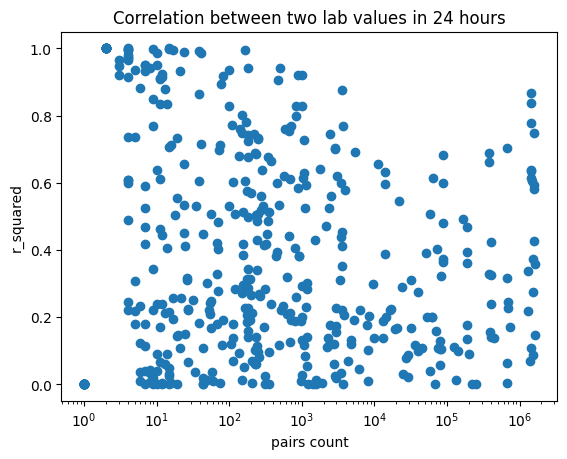

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter((result_df['cnt']),result_df['r_square'])
plt.xscale('log')

# Add labels and title
plt.xlabel('pairs count')
plt.ylabel('r_squared')
plt.title('Correlation between two lab values in 24 hours')


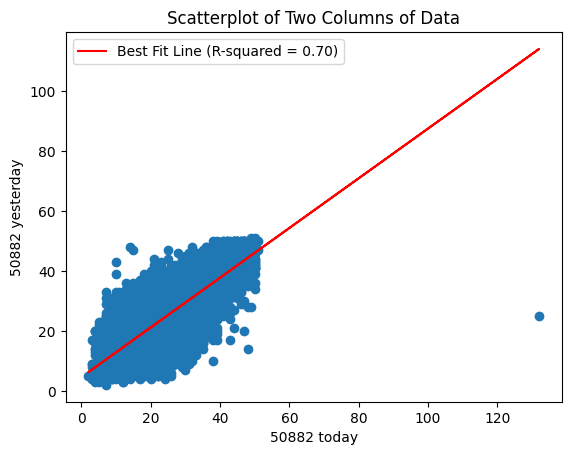

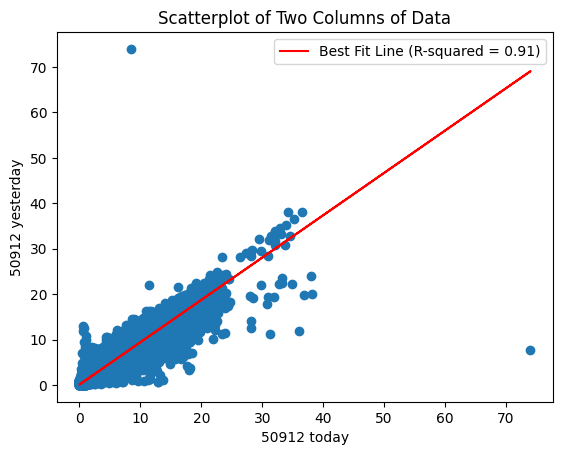

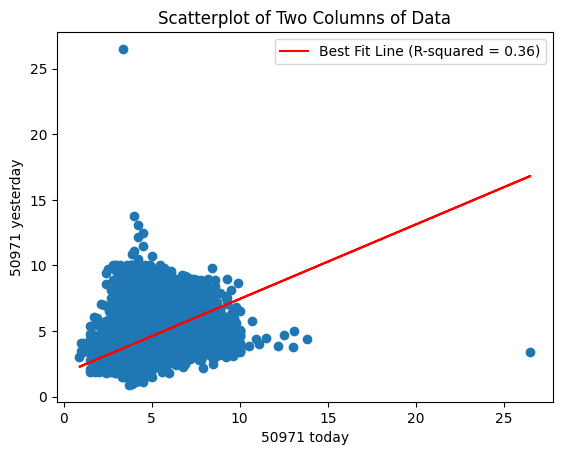

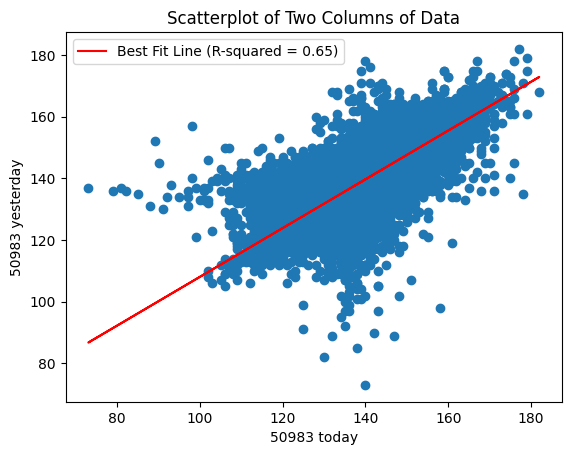

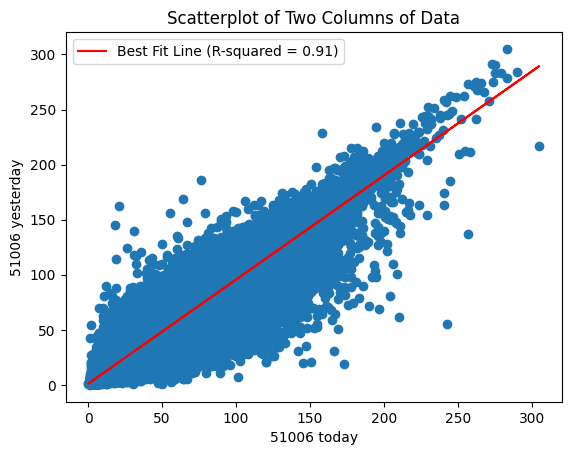

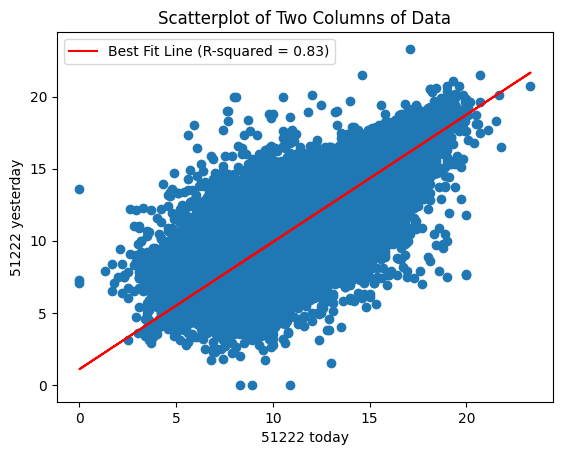

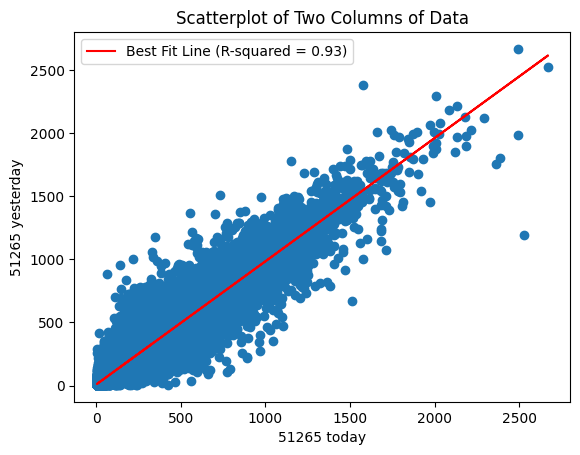

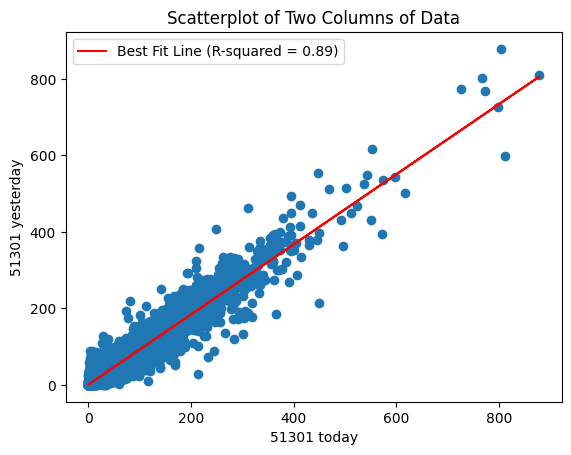

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

for item in columns_to_scale:
    x = df_merged[str(item)+"_yesterday"]
    y = df_merged[str(item)]

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value**2

    # Scatter plot
    plt.scatter(x, y)

    # Add regression line
    plt.plot(x, slope*x + intercept, color='red', label=f'Best Fit Line (R-squared = {r_squared:.2f})')

    plt.xlabel(str(item)+" today")
    plt.ylabel(str(item)+" yesterday")
    plt.title('Scatterplot of Two Columns of Data')
    plt.legend()

    # Show plot
    plt.show()